Inserting packages

In [20]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pathlib import Path
from movement.io import load_poses , save_poses
from movement.analysis.kinematics import compute_velocity
import pandas as pd

from utils import magnitude

Loading clean data

In [21]:
data_folder = Path("/Users/nsirmpilatze/Data/in2research2024")
clean_data_folder = data_folder / "clean_data"  
assert clean_data_folder.exists()

pair_names = ["SB019_female4", "SB019_male2", "SB021_female2", "SB021_male1"]
file_name = f"{pair_names[1]}_clean.csv"
file_path = clean_data_folder / file_name

velocity_folder = data_folder / "velocity_data"
velocity_folder.mkdir(exist_ok=True)

ds = load_poses.from_dlc_file(file_path, fps=50)
print(ds)


<xarray.Dataset> Size: 7MB
Dimensions:      (time: 14701, individuals: 2, keypoints: 10, space: 2)
Coordinates:
  * time         (time) float64 118kB 0.0 0.02 0.04 0.06 ... 294.0 294.0 294.0
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 5MB nan ... 357.1
    confidence   (time, individuals, keypoints) float64 2MB 0.2029 ... 0.9878
Attributes:
    fps:              50.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /Users/nsirmpilatze/Data/in2research2024/clean_data/SB0...


Computing distance between resident and intruder

In [22]:
centroid = ds.position.mean(dim="keypoints")
butt = ds.position.sel(keypoints="butt")    

In [23]:
dr = butt.sel(individuals="resident", drop=True)
di = butt.sel(individuals="intruder", drop=True)


position_diff = dr - di
distance = magnitude(position_diff)
distance

<xarray.DataArray 'position' (time: 14701)> Size: 118kB
291.8 291.3 291.3 291.1 289.5 263.7 ... 661.0 666.2 671.4 676.5 676.5 676.6
Coordinates:
  * time       (time) float64 118kB 0.0 0.02 0.04 0.06 ... 294.0 294.0 294.0
    keypoints  <U13 52B 'butt'

In [24]:
#distance.mean().values
median_distance = distance.median().values
mean_distance = distance.mean().values

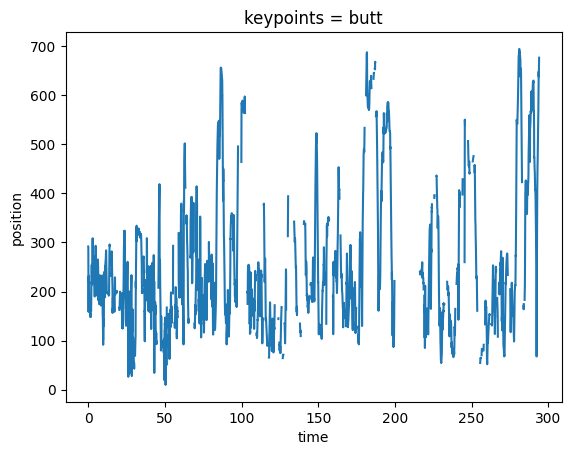

In [25]:
distance.plot.line(x="time")

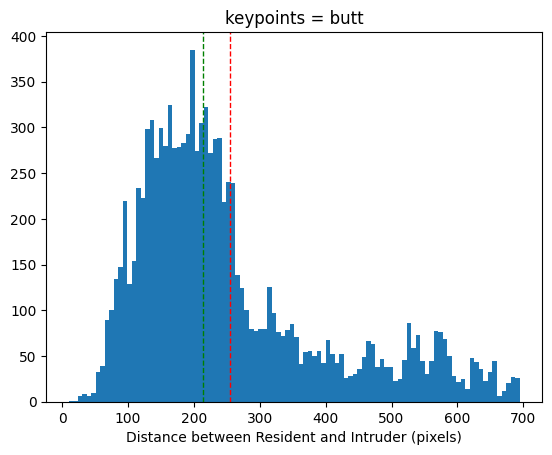

In [26]:
distance.plot.hist(bins=100)
ax = plt.gca()
ax.set_xlabel("Distance between Resident and Intruder (pixels)")
ax.axvline(mean_distance, color='r', linestyle='dashed', linewidth=1)
ax.axvline(median_distance, color='g', linestyle='dashed', linewidth=1)

In [27]:
distance_yousuf = np.sqrt(((dr - di)**2).sum(dim="space", skipna=False))
distance_yousuf

<xarray.DataArray 'position' (time: 14701)> Size: 118kB
291.8 291.3 291.3 291.1 289.5 263.7 ... 661.0 666.2 671.4 676.5 676.5 676.6
Coordinates:
  * time       (time) float64 118kB 0.0 0.02 0.04 0.06 ... 294.0 294.0 294.0
    keypoints  <U13 52B 'butt'

Computing velocity for each individual and keypoint

In [32]:
velocity = compute_velocity(butt)
#velocity.plot.line(x="time", row="keypoints",  hue="space", col="individuals", aspect=2, size=2.5)
#plt.gcf().show()
#plt.savefig(velocity_folder / f"{pair_names[0]}_velocity.png")

In [33]:
speed = magnitude(velocity)
speed.name = "speed (px/s)"
speed

<xarray.DataArray 'speed (px/s)' (time: 14701, individuals: 2)> Size: 235kB
23.56 0.0 11.78 0.0 2.147 12.04 45.07 ... 5.849 131.9 3.537 0.0 38.28 0.0 69.49
Coordinates:
  * time         (time) float64 118kB 0.0 0.02 0.04 0.06 ... 294.0 294.0 294.0
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
    keypoints    <U13 52B 'butt'

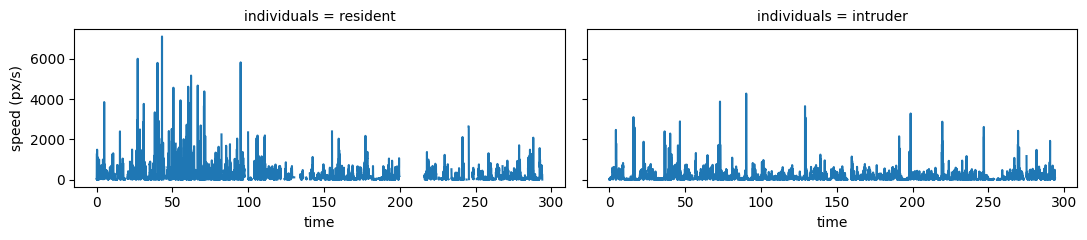

<Figure size 640x480 with 0 Axes>

In [34]:
speed.plot.line(x="time", col="individuals", aspect=2, size=2.5)
plt.show()
plt.savefig(velocity_folder / f"{pair_names[0]}_speed.png")

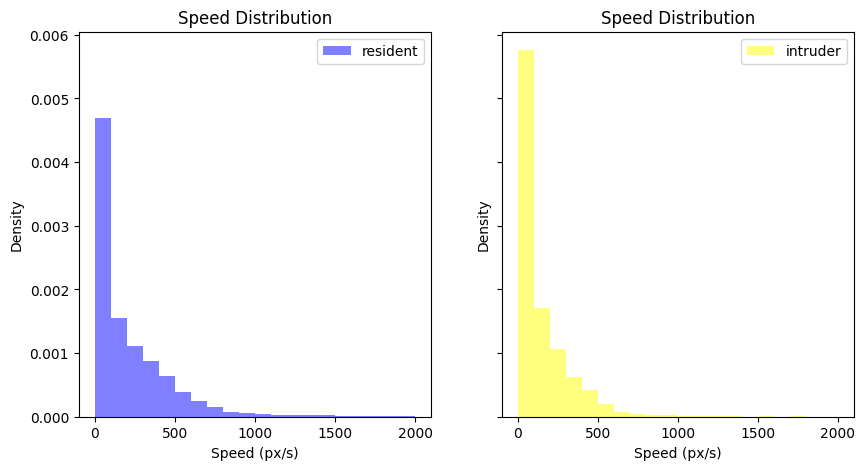

In [35]:
colors = ["blue", "yellow"]
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
speed.sel(individuals="resident").plot.hist(ax=ax[0], bins=np.linspace(0, 2000, 21), color=colors[0], alpha=0.5, label="resident", density=True);
speed.sel(individuals="intruder").plot.hist(ax=ax[1], bins=np.linspace(0, 2000, 21), color=colors[1], alpha=0.5, label="intruder", density=True);
for ax_i in ax:
    ax_i.set_xlabel("Speed (px/s)")
    ax_i.legend()
    ax_i.set_ylabel("Density")
    ax_i.set_title("Speed Distribution")
    #ytick_labels = ax_i.get_yticks() * 100
    #ax_i.set_yticklabels([f"{t:.2f}" for t in ytick_labels]);

#ax.set_title("Speed Distribution")